In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
print(calc_temps('2016-08-01', '2016-08-07'))

[(72.0, 77.79545454545455, 83.0)]


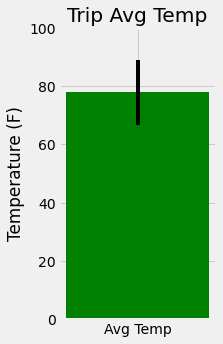

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x=['Avg Temp']
temps = [77.80]
variance = [11]

x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(2.5,5))
plt.bar(x_pos, temps, color='green', yerr=variance)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.ylim(0,100)


plt.xticks(x_pos,x)

plt.show()

### Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_rain = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.avg(Measurement.prcp)).\
                filter(Measurement.date>='2016-08-01').filter(Measurement.date<='2016-08-07').\
                filter(Measurement.station==Station.station).group_by(Measurement.station).\
                order_by(func.avg(Measurement.prcp).desc()).all()

station_rain_df = pd.DataFrame(station_rain, columns=['Station ID', 'Station Name', 'Latitude', 'Longitude', 'Elevation', 'Avg Precipitation'])
station_rain_df               
                

,Station ID,Station Name,Latitude,Longitude,Elevation,Avg Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.550000
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.860000
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.512857
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.343333
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.185714
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.081429
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.045000


In [25]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
print(daily_normals("08-01"))

[(67.0, 75.54, 83.0)]


In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
dates = ['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for date in dates:
    normals.append(daily_normals(date)[0])
    
print(normals)

[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0)]


In [27]:
mins = [x[0] for x in normals]
maxs =[x[2] for x in normals]
avgs = [x[1] for x in normals]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_df = pd.DataFrame({
    'Min Temp': mins,
    'Max Temp': maxs,
    'Avg Temp': avgs
}, index = dates)

temp_df

,Min Temp,Max Temp,Avg Temp
08-01,67.0,83.0,75.540000
08-02,68.0,84.0,75.603774
08-03,70.0,85.0,76.611111
08-04,69.0,84.0,76.711538
08-05,69.0,82.0,76.148148
08-06,67.0,83.0,76.250000
08-07,71.0,83.0,77.156863


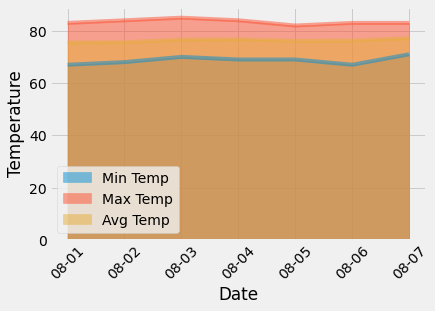

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
temp_df.plot.area(stacked=False, grid=True,)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.show()

## Close Session

In [36]:
session.close()